In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


# Amazon Customer Reviews Sentiment Analysis

**Goal:**  
Build a machine learning model to classify customer reviews as positive or negative.  
This project demonstrates text preprocessing, feature extraction (TF-IDF), and baseline machine learning models (Logistic Regression, Naive Bayes).  

**Business Context:**  
Understanding customer sentiment helps improve product feedback analysis and supports applications like customer service automation (chatbots, contact centers).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

### **Data Processing & EDA**

In [3]:
train_path = "/kaggle/input/amazonreviews/train.ft.txt.bz2"
test_path = "/kaggle/input/amazonreviews/test.ft.txt.bz2"

def load_dataset(path, nrows=None):
    df = pd.read_csv(path, sep="\t", header=None, names=["text"], nrows=nrows)
    df["label"] = df["text"].str.split(" ",n=1).str[0]
    df["review"] = df["text"].str.split(" ",n=1).str[1]
    df["label"] = df["label"].map({"__label__1": 0, "__label__2": 1})

    return df[["review", "label"]]


train_df = load_dataset(train_path, nrows=200000)
test_df = load_dataset(test_path, nrows=50000)

train_df.head()

,review,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [4]:
train_df["label"].value_counts()

label
1    101166
0     98834
Name: count, dtype: int64

In [5]:
import os
OUT_DIR = "/kaggle/working/figure"
os.makedirs(OUT_DIR, exist_ok=True)

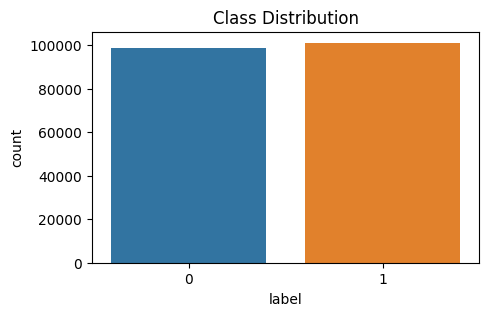

In [6]:
plt.figure(figsize=(5,3))
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution")
plt.savefig(OUT_DIR+"/Class_Distribution.png", dpi=200, bbox_inches="tight")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


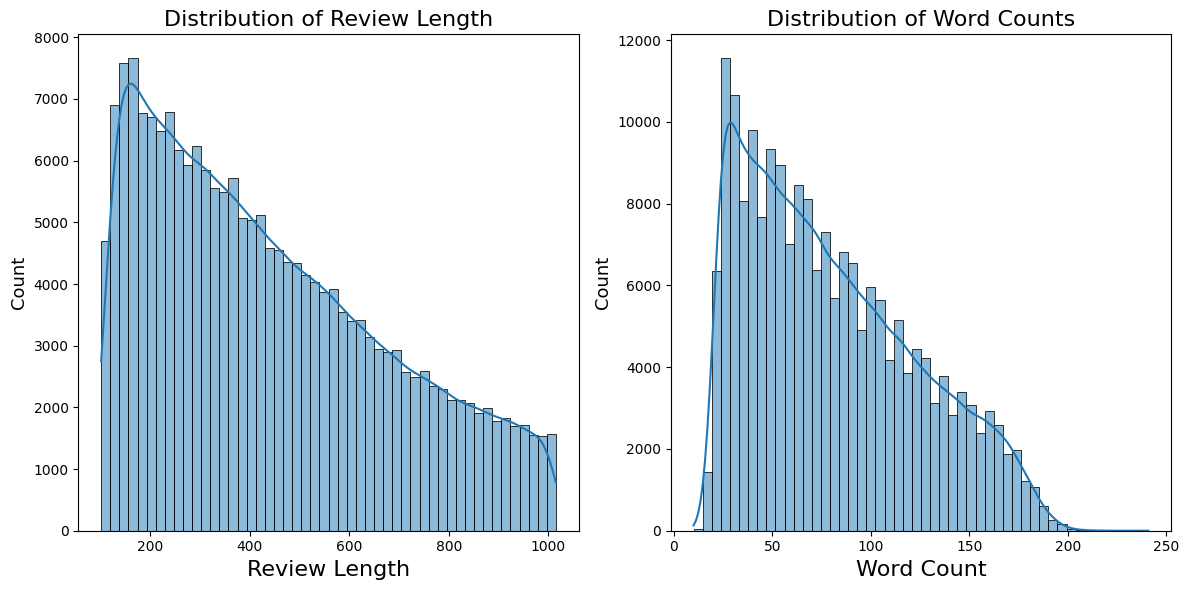

In [7]:
df = train_df.copy()
df["review_length"] = train_df["review"].str.len()
df["word_count"] = train_df["review"].str.split().str.len()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df["review_length"], bins=50, kde=True, ax=axs[0])
axs[0].set_xlabel("Review Length", fontsize=16)
axs[0].set_ylabel("Count", fontsize=13)
axs[0].set_title("Distribution of Review Length", fontsize=16)

sns.histplot(data=df["word_count"], bins=50, kde=True, ax=axs[1])
axs[1].set_xlabel("Word Count", fontsize=16)
axs[1].set_ylabel("Count", fontsize=13)
axs[1].set_title("Distribution of Word Counts", fontsize=16)

plt.savefig(OUT_DIR+"/Distiribution_Length_Count.png", dpi=200, bbox_inches="tight")
plt.tight_layout()
plt.show()

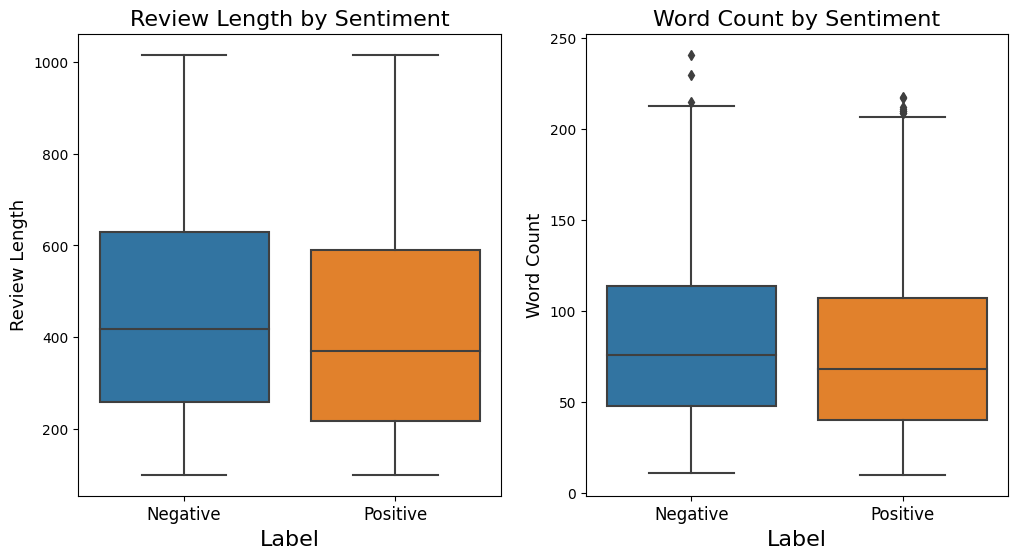

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x="label", y="review_length", data=df, ax=axs[0])
sns.boxplot(x="label", y="word_count", data=df, ax=axs[1])

axs[0].set_xticks([0,1], ["Negative", "Positive"], fontsize=12)
axs[0].set_xlabel("Label", fontsize=16)
axs[0].set_ylabel("Review Length", fontsize=13)
axs[0].set_title("Review Length by Sentiment", fontsize=16)

axs[1].set_xticks([0,1], ["Negative", "Positive"], fontsize=12)
axs[1].set_xlabel("Label", fontsize=16)
axs[1].set_ylabel("Word Count", fontsize=13)
axs[1].set_title("Word Count by Sentiment", fontsize=16)

plt.savefig(OUT_DIR+"/Review_By_Sentiment.png", dpi=200, bbox_inches="tight")
plt.show()

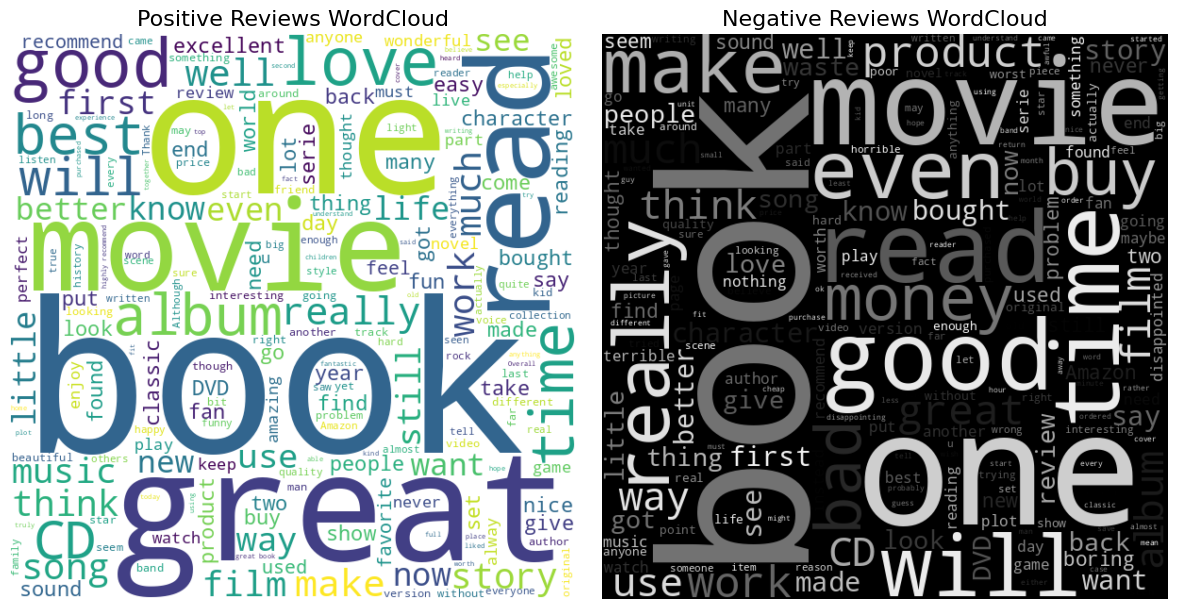

In [9]:
from wordcloud import WordCloud

df["review"] = train_df["review"]
positive_text = " ".join(df[df["label"]==1]["review"].sample(10000))
negative_text = " ".join(df[df["label"]==0]["review"].sample(10000))

wordcloud_pos = WordCloud(width=600, height=600, background_color="white").generate(positive_text)
wordcloud_neg = WordCloud(width=600, height=600, background_color="black", colormap="binary").generate(negative_text)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(wordcloud_pos, interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title("Positive Reviews WordCloud", fontsize=16)

axs[1].imshow(wordcloud_neg, interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title("Negative Reviews WordCloud", fontsize=16)
plt.savefig(OUT_DIR+"/WordCloud.png", dpi=200, bbox_inches="tight")
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


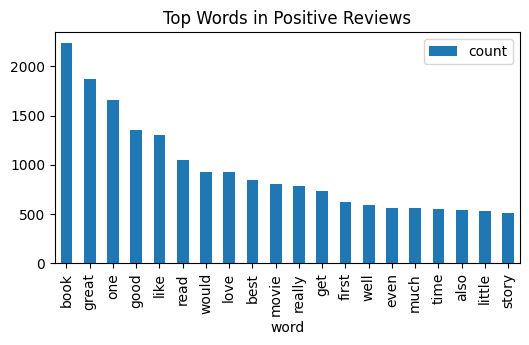

In [10]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

words = " ".join(df[df["label"]==1]["review"].sample(5000)).lower().split()
words = [w for w in words if w.isalpha() and w not in stop_words]
pos_common = Counter(words).most_common(20)

pd.DataFrame(pos_common, columns=["word", "count"]).plot.bar(x="word", y="count", figsize=(6,3), title="Top Words in Positive Reviews")
plt.savefig(OUT_DIR + "/Top_Words_in_Pos_Reviews.png", dpi=200)
plt.show()

## Data Preprocessing

In [11]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
        
    return " ".join(tokens)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [12]:
df['clean_review'] = df['review'].apply(preprocess_text)
df.head()

,review,label,review_length,word_count,clean_review
0,Stuning even for the non-gamer: This sound tra...,1,426,80,stuning even nongamer sound track beautiful pa...
1,The best soundtrack ever to anything.: I'm rea...,1,509,97,best soundtrack ever anything im reading lot r...
2,Amazing!: This soundtrack is my favorite music...,1,760,129,amazing soundtrack favorite music time hand in...
3,Excellent Soundtrack: I truly like this soundt...,1,743,118,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...",1,481,87,remember pull jaw floor hearing youve played g...


In [13]:
# Add "clear_review" column to train/test_df

if "clean_review" not in train_df.columns:
    train_df["clean_review"] = train_df["review"].astype(str).apply(preprocess_text)
    
if "clean_review" not in test_df.columns:
    test_df["clean_review"] = test_df["review"].astype(str).apply(preprocess_text)

## Feature Extraction (TF-IDF)

In [14]:
X_train, y_train = train_df["clean_review"].astype(str).tolist(), train_df["label"].values
X_test, y_test = test_df["clean_review"].astype(str).tolist(), test_df["label"].values

In [15]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_features=20000,
    stop_words="english",
    strip_accents="unicode"
)

In [16]:
X_tr = tfidf.fit_transform(X_train)
X_te = tfidf.transform(X_test)

## Model (LR + NB)

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

lr = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
m_nb = MultinomialNB()
c_nb = ComplementNB()

In [18]:
lr.fit(X_tr, y_train)
m_nb.fit(X_tr, y_train)

MultinomialNB()

In [19]:
c_nb.fit(X_tr, y_train)

ComplementNB()

In [20]:
pred_lr = lr.predict(X_te)
proba_lr = lr.predict_proba(X_te)[:,1]

pred_m_nb = m_nb.predict(X_te)
proba_m_nb = m_nb.predict_proba(X_te)[:, 1]

pred_c_nb = c_nb.predict(X_te)
proba_c_nb = c_nb.predict_proba(X_te)[:, 1]

## Evaluation

In [21]:
def summarize(name, y_true, y_pred, y_proba):
    acc  = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    roc  = roc_auc_score(y_true, y_proba)
    ap   = average_precision_score(y_true, y_proba)  # PR-AUC
    print(f"\n== {name} ==")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {ap:.4f}")
    print(classification_report(y_true, y_pred, digits=4))

In [22]:
from sklearn.metrics import average_precision_score

summarize("Logistic Regression", y_test, pred_lr, proba_lr)
summarize("Multinomial Naive Bayes", y_test, pred_m_nb, proba_m_nb)
summarize("Complement Naive Bayes", y_test, pred_c_nb, proba_c_nb)


== Logistic Regression ==
Accuracy: 0.8887 | Precision: 0.8871 | Recall: 0.8947 | F1: 0.8908
ROC-AUC: 0.9563 | PR-AUC: 0.9557
              precision    recall  f1-score   support

           0     0.8905    0.8826    0.8866     24626
           1     0.8871    0.8947    0.8908     25374

    accuracy                         0.8887     50000
   macro avg     0.8888    0.8887    0.8887     50000
weighted avg     0.8888    0.8887    0.8887     50000


== Multinomial Naive Bayes ==
Accuracy: 0.8580 | Precision: 0.8594 | Recall: 0.8610 | F1: 0.8602
ROC-AUC: 0.9350 | PR-AUC: 0.9354
              precision    recall  f1-score   support

           0     0.8565    0.8549    0.8557     24626
           1     0.8594    0.8610    0.8602     25374

    accuracy                         0.8580     50000
   macro avg     0.8580    0.8579    0.8579     50000
weighted avg     0.8580    0.8580    0.8580     50000


== Complement Naive Bayes ==
Accuracy: 0.8575 | Precision: 0.8622 | Recall: 0.8560 | F1

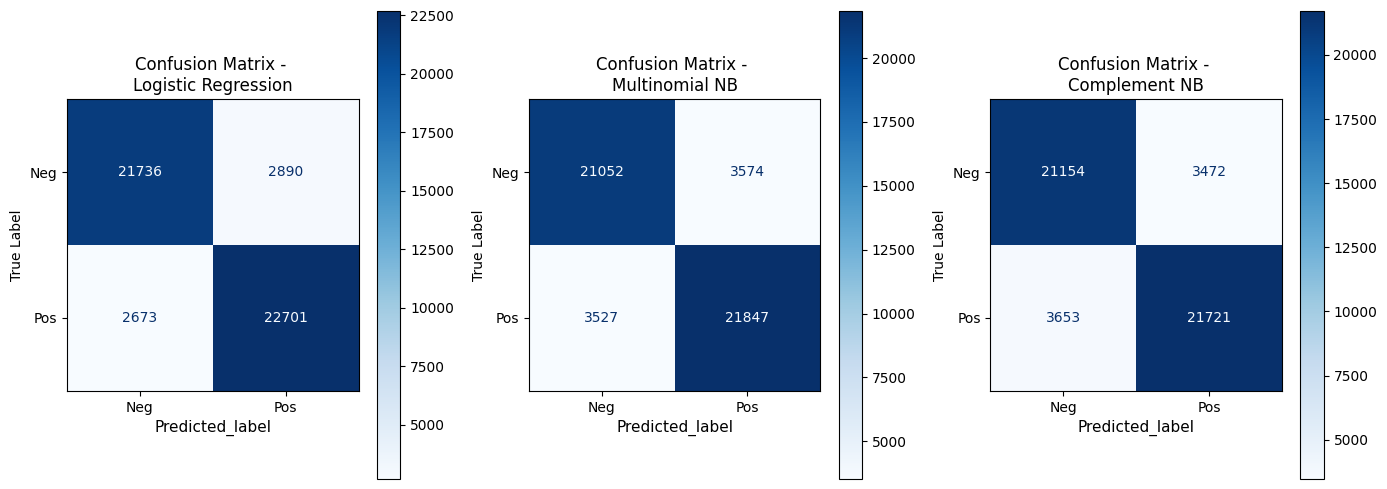

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 3, figsize=(14,5))
for ax, name, y_pred in [(axs[0],"\nLogistic Regression",pred_lr),(axs[1],"\nMultinomial NB",pred_m_nb), (axs[2],"\nComplement NB",pred_c_nb)]:
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=["Neg","Pos"]).plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"Confusion Matrix - {name}", fontsize=12)
    ax.set_xlabel("Predicted_label", fontsize=11)
    ax.set_ylabel("True Label", fontsize=10)
plt.savefig(OUT_DIR + "/ConfusionMatrix_LR_NB.png", dpi=200, bbox_inches="tight")
plt.tight_layout() 
plt.show()

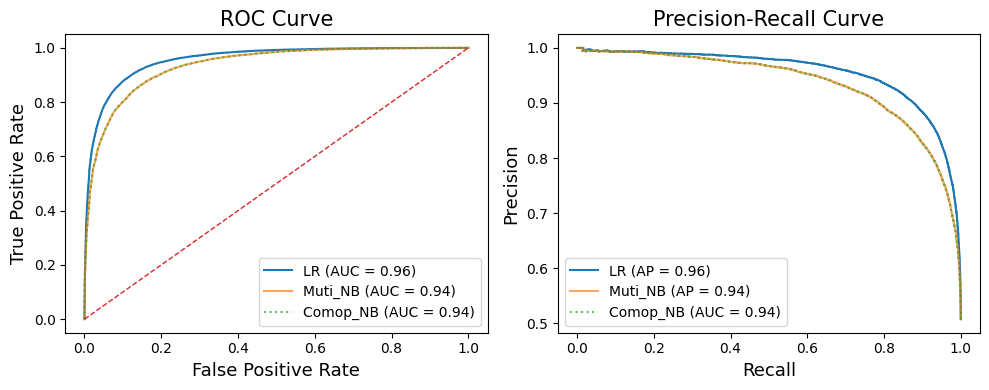

In [24]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)  # (y_true, y_score)
fpr_m_nb, tpr_m_nb, _ = roc_curve(y_test, proba_m_nb)
fpr_c_nb, tpr_c_nb, _ = roc_curve(y_test, proba_c_nb)

auc_lr, auc_m_nb, auc_c_nb = auc(fpr_lr, tpr_lr), auc(fpr_m_nb, tpr_m_nb), auc(fpr_c_nb, tpr_c_nb)

prec_lr, rec_lr, _ = precision_recall_curve(y_test, proba_lr)
prec_m_nb, rec_m_nb, _ = precision_recall_curve(y_test, proba_m_nb)
prec_c_nb, rec_c_nb, _ = precision_recall_curve(y_test, proba_c_nb)

ap_lr, ap_m_nb = average_precision_score(y_test, proba_lr), average_precision_score(y_test, proba_m_nb)
ap_c_nb = average_precision_score(y_test, proba_c_nb)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(fpr_lr, tpr_lr, label=f"LR (AUC = {auc_lr:.2f})")
axs[0].plot(fpr_m_nb, tpr_m_nb, label=f"Muti_NB (AUC = {auc_m_nb:.2f})", alpha=0.7, linestyle='-')
axs[0].plot(fpr_c_nb, tpr_c_nb, label=f"Comop_NB (AUC = {auc_c_nb:.2f})", alpha=0.7, linestyle=':')
axs[0].plot([0,1],[0,1],"--", lw=1)
axs[0].set_xlabel("False Positive Rate", fontsize=13)
axs[0].set_ylabel("True Positive Rate", fontsize=13)
axs[0].set_title("ROC Curve", fontsize=15)
axs[0].legend(loc='lower right')

axs[1].plot(rec_lr, prec_lr, label=f"LR (AP = {ap_lr:.2f})")
axs[1].plot(rec_m_nb, prec_m_nb, label=f"Muti_NB (AP = {ap_m_nb:.2f})", alpha=0.7, linestyle='-')
axs[1].plot(rec_c_nb, prec_c_nb, label=f"Comop_NB (AUC = {auc_c_nb:.2f})", alpha=0.7, linestyle=':')
axs[1].set_xlabel("Recall", fontsize=13)
axs[1].set_ylabel("Precision", fontsize=13); 
axs[1].set_title("Precision-Recall Curve", fontsize=15)
axs[1].legend(loc='lower left')


plt.savefig(OUT_DIR+"/ROC_AUC_PR_AP.png", dpi=200, bbox_inches="tight")
plt.tight_layout(); plt.show()

In [25]:
def best_threshold_by_f1(y_true, y_proba):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    i = np.nanargmax(f1[:-1])
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

thr_lr, f1_lr, p_lr, r_lr = best_threshold_by_f1(y_test, proba_lr)
thr_m_nb, f1_m_nb, p_m_nb, r_m_nb = best_threshold_by_f1(y_test, proba_m_nb)
thr_c_nb, f1_c_nb, p_c_nb, r_c_nb = best_threshold_by_f1(y_test, proba_c_nb)

print(f"\n[LR] Best F1 threshold={thr_lr:.3f} | F1={f1_lr:.4f} | P={p_lr:.4f} | R={r_lr:.4f}")
print(f"[M_NB] Best F1 threshold={thr_m_nb:.3f} | F1={f1_m_nb:.4f} | P={p_m_nb:.4f} | R={r_m_nb:.4f}")
print(f"[C_NB] Best F1 threshold={thr_c_nb:.3f} | F1={f1_c_nb:.4f} | P={p_c_nb:.4f} | R={r_c_nb:.4f}")


[LR] Best F1 threshold=0.439 | F1=0.8928 | P=0.8683 | R=0.9186
[M_NB] Best F1 threshold=0.461 | F1=0.8629 | P=0.8385 | R=0.8887
[C_NB] Best F1 threshold=0.455 | F1=0.8629 | P=0.8385 | R=0.8887


#### LR Feature Importance Top-N

In [26]:
feature_names = np.array(tfidf.get_feature_names_out())
coefs = lr.coef_.ravel()
topN = 100
top_pos_idx = np.argsort(coefs)[-topN:][::-1]
top_neg_idx = np.argsort(coefs)[:topN]

top_pos_feats = list(zip(feature_names[top_pos_idx], np.round(coefs[top_pos_idx], 3)))
top_neg_feats = list(zip(feature_names[top_neg_idx], np.round(coefs[top_neg_idx], 3)))
top_pos_df = pd.DataFrame(top_pos_feats, columns=["Word", "Coefs"])
top_neg_df = pd.DataFrame(top_neg_feats, columns=["Word", "Coefs"])

DF_DIR = "/kaggle/working/result_data"
os.makedirs(DF_DIR, exist_ok=True)
top_pos_df.to_csv(DF_DIR+"/top100_pos_feat.csv")
top_neg_df.to_csv(DF_DIR+"/top100_neg_feat.csv")

## Linear SVC

In [27]:
from sklearn.svm import LinearSVC

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        min_df=2,
        sublinear_tf=True,
        stop_words="english"
    )),
    ("clf", LinearSVC(
        C=1.0,
        class_weight=None,
        max_iter=2000,
        random_state=42
    ))
])

svm_pipe.fit(X_train, y_train)
svm_pred = svm_pipe.predict(X_test)
scores_svc = svm_pipe.decision_function(X_test)

In [28]:
summarize("Linear Support Vector Classification", y_test, svm_pred, scores_svc)


== Linear Support Vector Classification ==
Accuracy: 0.8861 | Precision: 0.8838 | Recall: 0.8930 | F1: 0.8884
ROC-AUC: 0.9551 | PR-AUC: 0.9542
              precision    recall  f1-score   support

           0     0.8886    0.8790    0.8837     24626
           1     0.8838    0.8930    0.8884     25374

    accuracy                         0.8861     50000
   macro avg     0.8862    0.8860    0.8861     50000
weighted avg     0.8861    0.8861    0.8861     50000



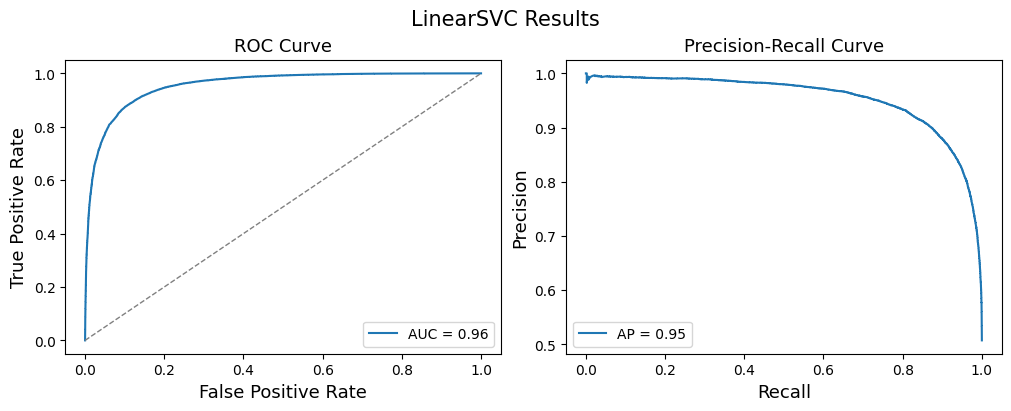

In [29]:
fpr, tpr, _ = roc_curve(y_test, scores_svc)
auc_roc = roc_auc_score(y_test, scores_svc)
prec, rec, _ = precision_recall_curve(y_test, scores_svc)
ap = average_precision_score(y_test, scores_svc)

fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
axs[0].plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
axs[0].plot([0,1],[0,1],"--", lw=1, color='grey')
axs[0].set_xlabel("False Positive Rate", fontsize=13)
axs[0].set_ylabel("True Positive Rate", fontsize=13)
axs[0].set_title("ROC Curve", fontsize=13)
axs[0].legend(loc='lower right')
axs[1].plot(rec, prec, label=f"AP = {ap:.2f}")
axs[1].set_xlabel("Recall", fontsize=13)
axs[1].set_ylabel("Precision", fontsize=13); 
axs[1].set_title("Precision-Recall Curve", fontsize=13)
axs[1].legend(loc='lower left')

fig.suptitle("LinearSVC Results", fontsize=15)
plt.savefig(OUT_DIR+"/LinearSVC_ROC_AUC_PR_AP.png", dpi=200, bbox_inches="tight")

## SVC + Hyperparameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tfidf__max_features": [10000, 20000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1.0, 2.0]
}

svm_search = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("\nGrid Search for SVM")
svm_search.fit(X_train, y_train)
print("Best Parameters:", svm_search.best_params_)

best_svm = svm_search.best_estimator_
svm_pred_best = best_svm.predict(X_test)
best_svm_score = best_svm.decision_function(X_test)
# evaluate(y_test, svm_pred_best, "Best LinearSVC (GridSearch)")


Grid Search for SVM
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'clf__C': 0.5, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}



== Best LinearSVC (GridSearch) ==
Accuracy: 0.8861 | Precision: 0.8838 | Recall: 0.8930 | F1: 0.8884
ROC-AUC: 0.9567 | PR-AUC: 0.9559
              precision    recall  f1-score   support

           0     0.8886    0.8790    0.8837     24626
           1     0.8838    0.8930    0.8884     25374

    accuracy                         0.8861     50000
   macro avg     0.8862    0.8860    0.8861     50000
weighted avg     0.8861    0.8861    0.8861     50000



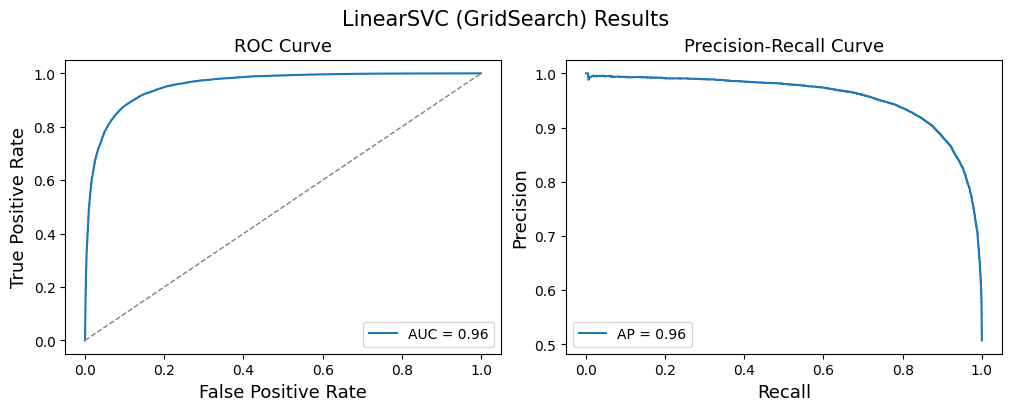

In [31]:
summarize("Best LinearSVC (GridSearch)", y_test, svm_pred, best_svm_score)

fpr, tpr, _ = roc_curve(y_test, best_svm_score)
auc_roc = roc_auc_score(y_test, best_svm_score)
prec, rec, _ = precision_recall_curve(y_test, best_svm_score)
ap = average_precision_score(y_test, best_svm_score)

fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
axs[0].plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
axs[0].plot([0,1],[0,1],"--", lw=1, color='grey')
axs[0].set_xlabel("False Positive Rate", fontsize=13)
axs[0].set_ylabel("True Positive Rate", fontsize=13)
axs[0].set_title("ROC Curve", fontsize=13)
axs[0].legend(loc='lower right')
axs[1].plot(rec, prec, label=f"AP = {ap:.2f}")
axs[1].set_xlabel("Recall", fontsize=13)
axs[1].set_ylabel("Precision", fontsize=13); 
axs[1].set_title("Precision-Recall Curve", fontsize=13)
axs[1].legend(loc='lower left')

fig.suptitle("LinearSVC (GridSearch) Results", fontsize=15)
plt.savefig(OUT_DIR+"/LinearSVC_GridSearch_ROC_AUC_PR_AP.png", dpi=200, bbox_inches="tight")

## XGBoost

In [32]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        min_df=2,
        sublinear_tf=True,
        stop_words="english"
    )),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.15,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        n_jobs=-1,
        random_state=42,
        tree_method="gpu_hist",
        eval_metric="logloss"
    ))
])


xgb_pipe.fit(X_train, y_train)

xgb_pred = xgb_pipe.predict(X_test)
xgb_proba = xgb_pipe.predict_proba(X_test)[:,1]
# evaluate(y_test, xgb_pred, "XGBoost (TF-IDF)")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:26:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:26:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:26:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.



== XGBoost (TF-IDF) ==
Accuracy: 0.5894 | Precision: 0.7569 | Recall: 0.2813 | F1: 0.4102
ROC-AUC: 0.5965 | PR-AUC: 0.5843
              precision    recall  f1-score   support

           0     0.5505    0.9069    0.6851     24626
           1     0.7569    0.2813    0.4102     25374

    accuracy                         0.5894     50000
   macro avg     0.6537    0.5941    0.5477     50000
weighted avg     0.6553    0.5894    0.5456     50000



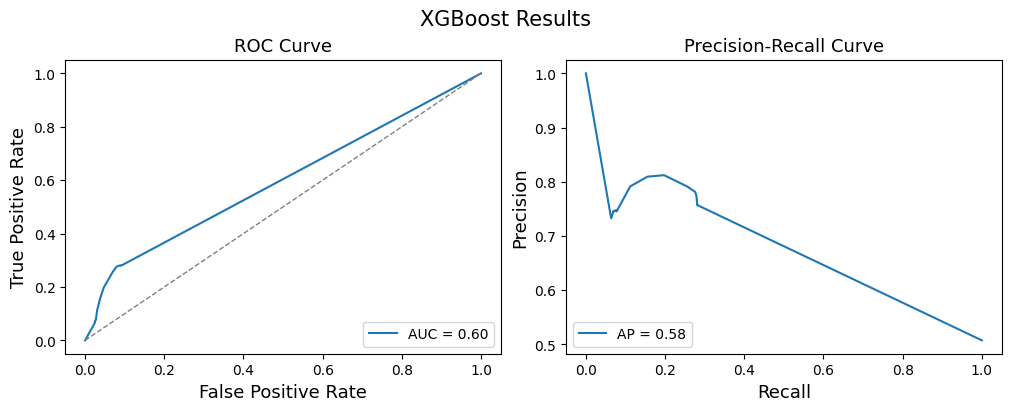

In [33]:
summarize("XGBoost (TF-IDF)", y_test, xgb_pred, xgb_proba)

fpr, tpr, _ = roc_curve(y_test, xgb_proba)
auc_roc = roc_auc_score(y_test, xgb_proba)
prec, rec, _ = precision_recall_curve(y_test, xgb_proba)
ap = average_precision_score(y_test, xgb_proba)

fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
axs[0].plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
axs[0].plot([0,1],[0,1],"--", lw=1, color='grey')
axs[0].set_xlabel("False Positive Rate", fontsize=13)
axs[0].set_ylabel("True Positive Rate", fontsize=13)
axs[0].set_title("ROC Curve", fontsize=13)
axs[0].legend(loc='lower right')
axs[1].plot(rec, prec, label=f"AP = {ap:.2f}")
axs[1].set_xlabel("Recall", fontsize=13)
axs[1].set_ylabel("Precision", fontsize=13); 
axs[1].set_title("Precision-Recall Curve", fontsize=13)
axs[1].legend(loc='lower left')

fig.suptitle("XGBoost Results", fontsize=15)
plt.savefig(OUT_DIR+"/XGBoost_ROC_AUC_PR_AP.png", dpi=200, bbox_inches="tight")

### Finding the Best Hyperparameters

In [34]:
from scipy.stats import uniform, randint

xgb = XGBClassifier(
    objective="binary:logistic",
    n_jobs=-1,
    random_state=42,
    tree_method="gpu_hist", # Keep using GPU
    eval_metric="logloss"
)

# Define the hyperparameter distribution for the random search
param_dist = {
    'learning_rate': uniform(0.05, 0.25),
    'n_estimators': randint(100, 500), # Set a wide range; early stopping will optimize this later
    'max_depth': randint(4, 7),
    'subsample': uniform(0.7, 0.3), # [0.7, 1.0] range
    'colsample_bytree': uniform(0.7, 0.3), # [0.7, 1.0] range
    'reg_lambda': uniform(0.5, 2.0)
}

In [35]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=param_dist, 
    n_iter=10, # Increase or decrease iterations based on available time
    cv=3, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_tr, y_train)

# Store the best parameters found
best_params = random_search.best_params_
print("\nBest parameters found:", best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:26:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:26:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:26:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW


Best parameters found: {'colsample_bytree': 0.8147385973801488, 'learning_rate': 0.29580772145169704, 'max_depth': 4, 'n_estimators': 230, 'reg_lambda': 2.219880813472641, 'subsample': 0.9040922615763338}


### Training the Final Model with Early Stopping

In [36]:
# We split the main training set (X_tr) into a smaller training set and a validation set.
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tr, y_train, test_size=0.2, random_state=42, stratify=y_train
)

final_xgb = XGBClassifier(**best_params,
                          objective="binary:logistic",
                          n_jobs=-1,
                          random_state=42,
                          tree_method="gpu_hist",
                          eval_metric="logloss"
                         )

print("\nTraining final model with Early Stopping")
final_xgb.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50, # If validation score doesn't improve for 50 rounds, stop training.
    verbose=100
)

# The model is now trained with the optimal number of trees.
print(f"\nOptimal number of trees found: {final_xgb.best_iteration}")

# Evaluate on the hold-out test set (X_te)
y_pred_proba = final_xgb.predict_proba(X_te)[:, 1]
y_pred = final_xgb.predict(X_te)


# print("\n--- Final Model Performance on Test Set ---")
# print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
# print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


Training final model with Early Stopping


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.75540


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:30:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[56]	validation_0-logloss:0.85738

Optimal number of trees found: 7


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:30:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



== XGBoost with Best Hyperparameters ==
Accuracy: 0.6018 | Precision: 0.7543 | Recall: 0.3195 | F1: 0.4488
ROC-AUC: 0.6549 | PR-AUC: 0.6374
              precision    recall  f1-score   support

           0     0.5601    0.8928    0.6883     24626
           1     0.7543    0.3195    0.4488     25374

    accuracy                         0.6018     50000
   macro avg     0.6572    0.6061    0.5686     50000
weighted avg     0.6586    0.6018    0.5668     50000



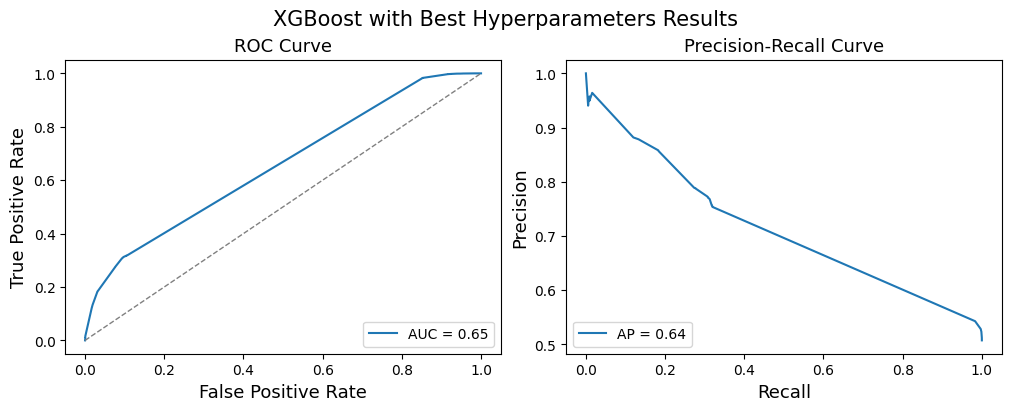

In [37]:
summarize("XGBoost with Best Hyperparameters", y_test, y_pred, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_roc = roc_auc_score(y_test, y_pred_proba)
prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
axs[0].plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
axs[0].plot([0,1],[0,1],"--", lw=1, color='grey')
axs[0].set_xlabel("False Positive Rate", fontsize=13)
axs[0].set_ylabel("True Positive Rate", fontsize=13)
axs[0].set_title("ROC Curve", fontsize=13)
axs[0].legend(loc='lower right')
axs[1].plot(rec, prec, label=f"AP = {ap:.2f}")
axs[1].set_xlabel("Recall", fontsize=13)
axs[1].set_ylabel("Precision", fontsize=13); 
axs[1].set_title("Precision-Recall Curve", fontsize=13)
axs[1].legend(loc='lower left')

fig.suptitle("XGBoost with Best Hyperparameters Results", fontsize=15)
plt.savefig(OUT_DIR+"/XGBoost_withBH_ROC_AUC_PR_AP.png", dpi=200, bbox_inches="tight")